# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

# Lab 7: Missingness & Classification
### (Logistic Regression, Multiple Logistic Regression, and kNN Classification)

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas & Kevin Rader<br/>
<hr style='height:2px'>

In [1]:
## UNCOMMENT & RUN THIS CELL (if not on Ed)
# import requests
# from IPython.core.display import HTML
# styles = requests.get(
#     "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
# ).text
# HTML(styles)

For this lab we will be using the following packages:

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# NEW packages
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import LinearRegression 
from sklearn.impute import SimpleImputer, KNNImputer

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

    
## Contents
    
### In this lab we will be covering Missingness, Linear Regression, Logistic Regression, and kNN Classification using the Iris dataset.

----
    

**Specifically, we will:**
 
0. [Dealing with Missing Data](#missingness)

1. [Import and explore data](#data)

2. [Fit a LINEAR regression model for classification, understand drawbacks, and interpret results](#linear)

3. [Fit a simple LOGISTIC regression model for classification, compare performance, and interpret results](#logistic)

4. [Visualize predictions and decision boundaries](#plot)

5. [Fit a higher order polynomial logistic regression model for classification, compare performance, plot decision boundaries, and interpret results](#poly)

6. [Consider the impact of different regularization parameters on the above polynomial model](#regularize)

7. [Fit and investigate a kNN CLASSIFIER](#knn)

8. [Review `sklearn` pipelines](#pipeline)

**For our team exercises, we will:**

1. [Standardize our data and fit a simple logistic regression model](#ex1)

2. [Plot and examine decision boundaries](#ex2)

3. [Add an interaction term and use `LogisticRegressionCV` to cross-validate a regularization parameter](#ex3)

By the end, we hope you will be comfortable building your own classification models.
    


There is another type of multiple logistic regression <a href = "https://en.wikipedia.org/wiki/Multinomial_logistic_regression">(multinomial logistic regression)</a> which strictly enforces that the probabilities will sum to one.

# 0. Dealing with Missingness

<a id='data'></a>

## Missing Data
We'll create data of the form:
$$ y = 3x_1 - 2x_2 + \varepsilon,\hspace{0.1in} \varepsilon \sim N(0,1)$$

We will then be inserting missingness into `x1` in various ways, and analyzing the results of different methods for handling those missing values.

In [3]:
# Number of data points to generate
n = 500
# Set random seed for numpy to ensure reproducible results
np.random.seed(109)
# Generate our predictors...
x1 = np.random.normal(0, 1, size=n)
x2 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
X = pd.DataFrame(data=np.transpose([x1,x2]),columns=["x1","x2"])
# Generate our response...
y = 3*x1 - 2*x2 + np.random.normal(0, 1, size=n)
y = pd.Series(y)
# And put them all in a nice DataFrame
df = pd.DataFrame(data=np.transpose([x1, x2, y]), columns=["x1", "x2", "y"]) 

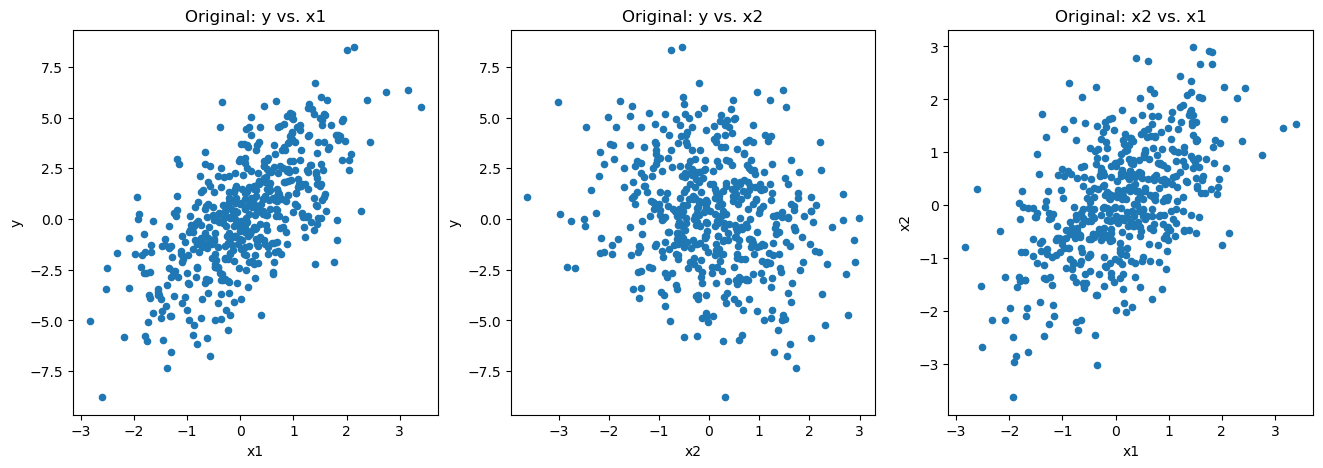

In [4]:
fig, axs =  plt.subplots(1, 3, figsize = (16,5))

plot_pairs = [('x1', 'y'), ('x2', 'y'), ('x1', 'x2')]
for ax, (x_var, y_var) in zip(axs, plot_pairs):
    df.plot.scatter(x_var, y_var, ax=ax, title=f'Original: {y_var} vs. {x_var}')

### Poke holes in $X_1$ in 3 different ways: 

- **Missing Completely at Random** (MCAR): missingness is not predictable.
- **Missing at Random** (MAR): missingness depends on other observed data, and thus can be recovered in some way
- **Missingness not at Random** (MNAR): missingness depends on unobserved data and thus cannot be recovered


Here we generate indices of $X_1$ to be dropped due to 3 types of missingness using $n$ single bernoulli trials.\
The only difference between the 3 sets of indices is the probabilities of success for each trial (i.e., the probability that a given observation will be missing).

In [5]:
# Missing completely at random, no dependence
missing_MCAR = np.random.binomial(1, 0.2, n).astype(bool) 

# Missing at Random, missing that depends on another observed variable
missing_MAR = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())),  n).astype(bool)

# Missing not at Random
# Missing based on other variable that is also missing
x3 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
missing_MNAR = np.random.binomial(1, 0.05 + 0.85*(x3 > (x3.mean()+x3.std())), n).astype(bool)

In [6]:
# Helper function to replace x_1 with nan at specified indices
def create_missing(missing_indices, df=df):
    df_new = df.copy()
    df_new.loc[missing_indices, 'x1'] = np.nan
    return df_new

In [7]:
# Missing completely at random (MCAR)
df_mcar = create_missing(missing_indices=missing_MCAR)

# Missing at random (MAR)
df_mar = create_missing(missing_indices=missing_MAR)

# Missing not at random (MNAR)
df_mnar = create_missing(missing_indices=missing_MNAR)

In [8]:
display(df)
display(df_mcar)

,x1,x2,y
0,-0.187735,1.190834,-1.687270
1,2.440637,2.214195,3.816174
2,-0.940908,-0.474695,-0.564044
3,0.613912,1.434117,-2.632183
4,0.735627,1.282782,0.133237
...,...,...,...
495,0.985536,-0.663080,4.940357
496,2.046700,1.637581,2.904765
497,-1.646025,-2.760402,-0.110912
498,-0.974043,-0.799473,-0.647466


,x1,x2,y
0,-0.187735,1.190834,-1.687270
1,2.440637,2.214195,3.816174
2,-0.940908,-0.474695,-0.564044
3,NaN,1.434117,-2.632183
4,0.735627,1.282782,0.133237
...,...,...,...
495,NaN,-0.663080,4.940357
496,2.046700,1.637581,2.904765
497,-1.646025,-2.760402,-0.110912
498,-0.974043,-0.799473,-0.647466


Detecting missingness with `.isna()`

In [9]:
# Select just the rows with missing `x1` values
df_mcar[df_mcar.x1.isna()]

,x1,x2,y
3,NaN,1.434117,-2.632183
5,NaN,0.102881,3.947541
11,NaN,-3.013140,5.766006
12,NaN,0.320763,3.546810
16,NaN,0.772822,-3.014202
...,...,...,...
479,NaN,2.984959,0.057694
481,NaN,-0.079927,-0.832751
490,NaN,-0.748489,8.316091
495,NaN,-0.663080,4.940357


Simple imputation of the mean.

In [10]:
# fill missing value with mean of given column
df_mcar_fillx1 = df_mcar.copy()
df_mcar_fillx1['x1'] = df_mcar['x1'].fillna(df_mcar['x1'].mean())
df_mcar_fillx1

,x1,x2,y
0,-0.187735,1.190834,-1.687270
1,2.440637,2.214195,3.816174
2,-0.940908,-0.474695,-0.564044
3,0.053293,1.434117,-2.632183
4,0.735627,1.282782,0.133237
...,...,...,...
495,0.053293,-0.663080,4.940357
496,2.046700,1.637581,2.904765
497,-1.646025,-2.760402,-0.110912
498,-0.974043,-0.799473,-0.647466


`fillna()` allows you to fill NaNs with any arbitrary value.

In [11]:
# fill missing value with mean of given column
df_mcar_fill2 = df_mcar.copy()
df_mcar_fill2['x1'] = df_mcar['x1'].fillna(1000)
df_mcar_fill2

,x1,x2,y
0,-0.187735,1.190834,-1.687270
1,2.440637,2.214195,3.816174
2,-0.940908,-0.474695,-0.564044
3,1000.000000,1.434117,-2.632183
4,0.735627,1.282782,0.133237
...,...,...,...
495,1000.000000,-0.663080,4.940357
496,2.046700,1.637581,2.904765
497,-1.646025,-2.760402,-0.110912
498,-0.974043,-0.799473,-0.647466


<img src="fig/missing.png" width="1000">

In [12]:
# indicator predictor
df_mcar_ind = df_mcar.copy()
df_mcar_ind['x1_miss'] = df_mcar['x1'].isna() * 1
df_mcar_ind['x2_miss'] = df_mcar['x2'].isna() * 1
display(df_mcar_ind)

,x1,x2,y,x1_miss,x2_miss
0,-0.187735,1.190834,-1.687270,0,0
1,2.440637,2.214195,3.816174,0,0
2,-0.940908,-0.474695,-0.564044,0,0
3,NaN,1.434117,-2.632183,1,0
4,0.735627,1.282782,0.133237,0,0
...,...,...,...,...,...
495,NaN,-0.663080,4.940357,1,0
496,2.046700,1.637581,2.904765,0,0
497,-1.646025,-2.760402,-0.110912,0,0
498,-0.974043,-0.799473,-0.647466,0,0


In [13]:
df_mcar_ind['x1'] = df_mcar['x1'].fillna(df_mcar['x1'].mean())
df_mcar_ind['x2'] = df_mcar['x2'].fillna(df_mcar['x2'].mean())
display(df_mcar_ind)

,x1,x2,y,x1_miss,x2_miss
0,-0.187735,1.190834,-1.687270,0,0
1,2.440637,2.214195,3.816174,0,0
2,-0.940908,-0.474695,-0.564044,0,0
3,0.053293,1.434117,-2.632183,1,0
4,0.735627,1.282782,0.133237,0,0
...,...,...,...,...,...
495,0.053293,-0.663080,4.940357,1,0
496,2.046700,1.637581,2.904765,0,0
497,-1.646025,-2.760402,-0.110912,0,0
498,-0.974043,-0.799473,-0.647466,0,0


### Sklearn module to impute missing data 

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute
<img src="fig/sklearn.png" width="1000">

# Student Exercise:
Consider the 3 processes below for generating missingness in `x1`.

Discuss with your neighbor which type of missingness the following three variables (missing_A, missing_B, and missing_C) correspond to, based on our discussion.

In [14]:
# Student Exercise: 

missing_A = np.random.binomial(1, 0.2, n).astype(bool) 

x3 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)
missing_B = np.random.binomial(1, 0.05 + 0.85*(x3 > (x3.mean()+x3.std())), n).astype(bool)

missing_C = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())),  n).astype(bool)


# 1. Load Iris Data

**For Lab 7 we will be using datasets available directly within `sklearn`.**

- For lab examples, we will be using Fisher's famous "Iris" dataset
- For our team exercises, we will be using the "Wine" dataset

To learn more about `sklearn` datasets, please see the documentation: https://scikit-learn.org/stable/datasets/toy_dataset.html

In [15]:
dataset = datasets.load_iris()
print(dataset.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


#### What are our the target and features? 

In [16]:
print(dataset.target_names)
print(dataset.feature_names)

# Uncomment if you want to see much, much more info on this dataset
#print(dataset['DESCR'])

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


<img src="fig/fischer.jpg" width="150px" style="float:right; margin: 30px">

**As we can see, the response variable (y) is the flower type, it has 3 classes:**

- setosa
- versicolor 
- virginica

These are three different species of Iris flowers.

**The 4 predictor variables are flower characteristics (x):**

- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)


Although this is a toy dataset, in real datasets it will be important to understand the underlying features. Below is a comparison of the three species and their sepals/petals, as well as the overall flower.

<img src="fig/iris_yong_cui_towarddatascience.png" width="700">

In [17]:
type(dataset.data)

numpy.ndarray

In [18]:
#create design matrix
X = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
print(X.shape)
display(X.head())
display(X.describe())

(150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [19]:
#create response variable
y = pd.DataFrame(data=dataset.target, columns=['species'])
print(y.shape)

(150, 1)


In [20]:
display(y.head())
display(y.describe())

,species
0,0
1,0
2,0
3,0
4,0


,species
count,150.000000
mean,1.000000
std,0.819232
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


### Explore Data 

Check which variables have high correlations and distinctive patterns with the response. 

Any patterns worth mentioning?

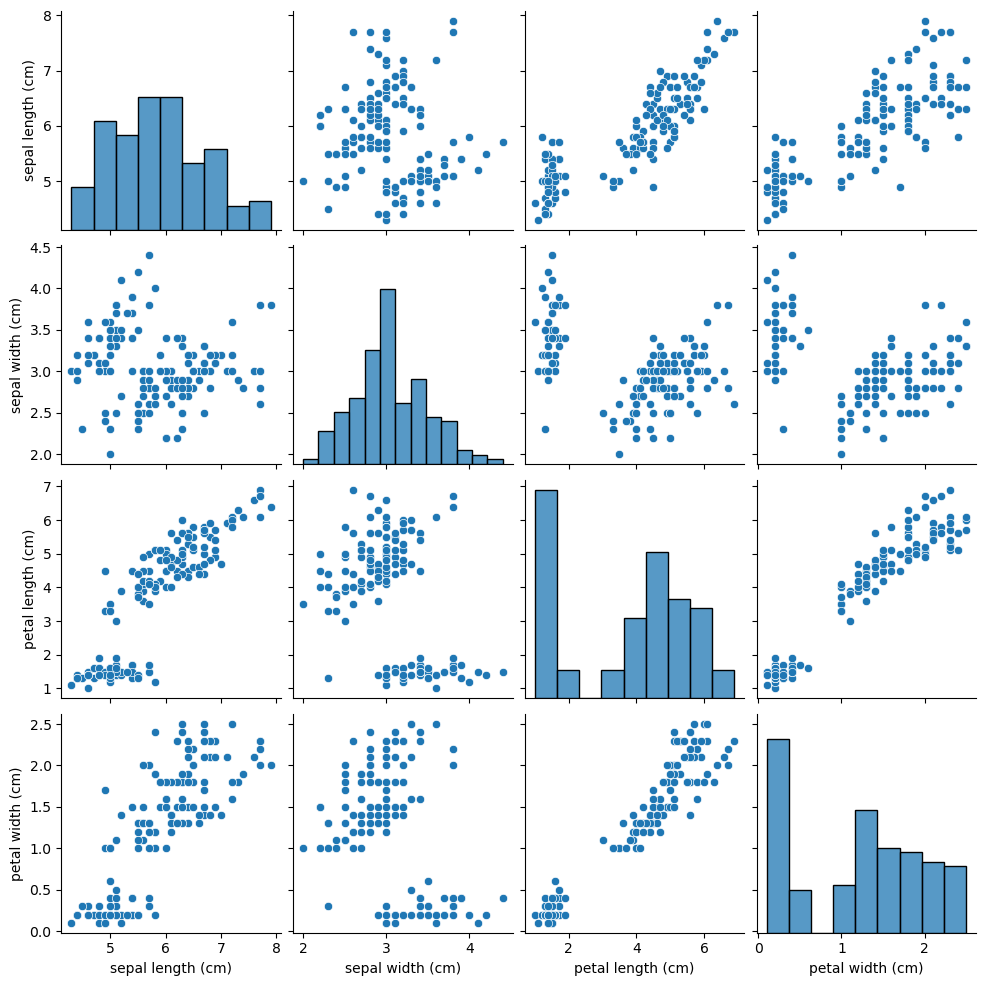

In [21]:
sns.pairplot(X)
plt.show()

**Are the features sepal/petal length and width uniformally distributed or do you observe some clusters of data points?**

What do you expect? Let's add color according to our response variable with `hue='species'`.

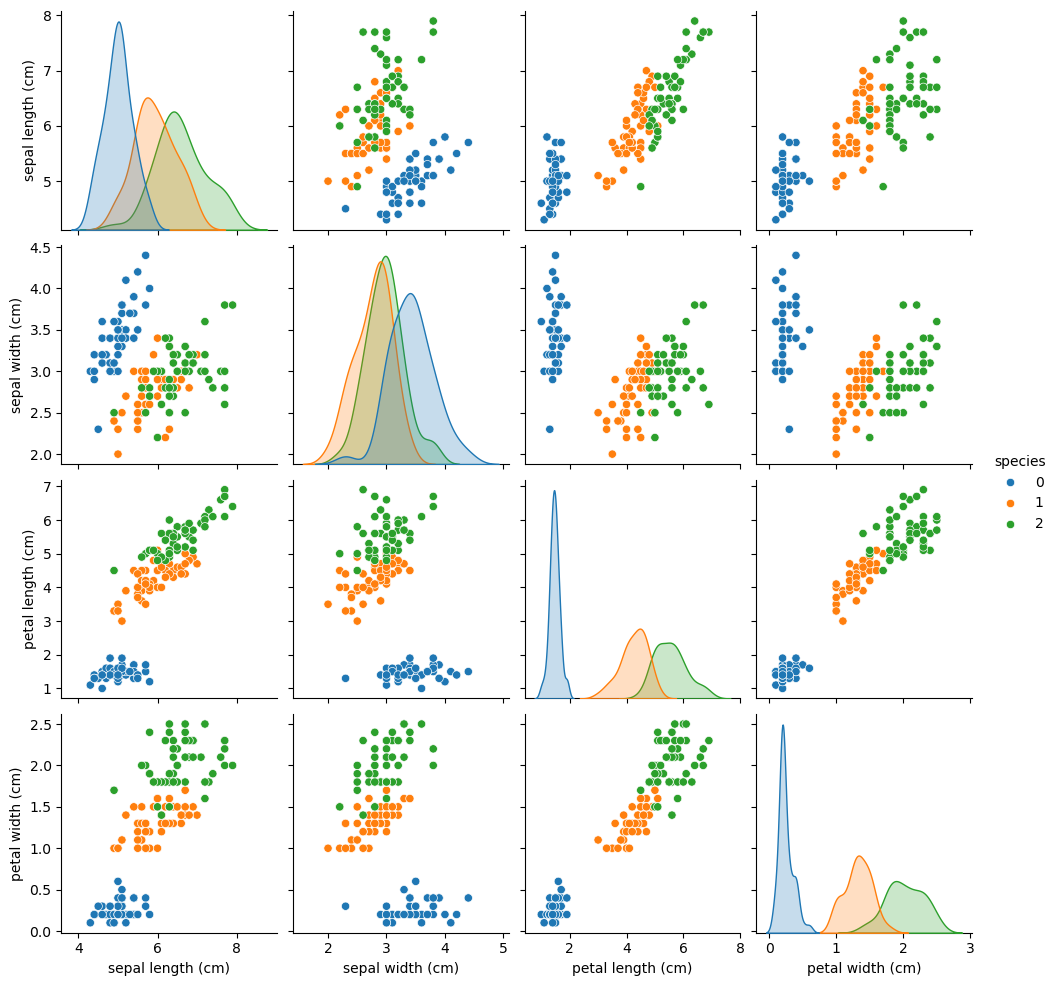

In [22]:
full_df = pd.concat([X,y], axis=1)
sns.pairplot(full_df, hue='species', palette = sns.color_palette("tab10")[:3])
plt.show()

Some features like 'petal length' and 'petal width' do have very high correlations and distinctive patterns with the response variable 'flower species'. When we would use these features for predicting the flower species, the classification wouldn't be very difficult. Certain ranges of 'petal length' and 'petal width' are very much correlated with a specific flower species and they are almost seperating our classes perfectly.

**Just for illustration purposes we will continue to use only `'sepal width (cm)'` and `'sepal length (cm)'`. We are making the problem harder for ourselves by only using 'weaker' or less-discriminative features.**

In [23]:
X = X[['sepal width (cm)', 'sepal length (cm)']]

### Train-Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

print('X_test.shape', X_test.shape)
print('y_test.shape',y_test.shape)

X_train.shape (100, 2)
y_train.shape (100, 1)
X_test.shape (50, 2)
y_test.shape (50, 1)


<a id='linear'></a>

## 2. Fit a LINEAR regression model for classification, understand drawbacks, and interpret results

[▲ Return to contents](#Contents)

In [26]:
model_linear_sklearn = LinearRegression()

#Training
model_linear_sklearn.fit(X_train, y_train)

#Predict
y_pred_train = model_linear_sklearn.predict(X_train)
y_pred_test = model_linear_sklearn.predict(X_test)

#Perfromance Evaluation
try:
    train_score = accuracy_score(y_train, y_pred_train)*100
    test_score = accuracy_score(y_test, y_pred_test)*100

    print("Training Set Accuracy:",str(train_score)+'%')
    print("Testing Set Accuracy:",str(test_score)+'%')
except Exception as e:
    print("ERROR!")
    print(e)

ERROR!
Classification metrics can't handle a mix of multiclass and continuous targets


<div class='exercise-r'>  
 
**QUESTION: Can anyone explain why we are getting an error? What is wrong with `y_train` and `y_pred_train`?**

</div>

In [27]:
print(y_train[:5], y_train.dtypes)

     species
96         1
105        2
66         1
0          0
122        2 species    int64
dtype: object


In [28]:
y_pred_train[:5]

array([[1.01761878],
       [2.33100162],
       [0.88117842],
       [0.19897661],
       [2.53139119]])

**The fact that our linear regression is outputting continuous predictions is one of the major drawbacks of linear regression for classification. We can solve this in two manners:**

- Simply rounding our prediction by using `np.round()` and converting it to an int data type with `.astype(int)`


- Or, use a modified algorithm that has bounded outputs (more about Logistic Regression later)

In [29]:
np.round(y_pred_train[:5])

array([[1.],
       [2.],
       [1.],
       [0.],
       [3.]])

In [30]:
np.round(y_pred_train[:5]).astype(int)

array([[1],
       [2],
       [1],
       [0],
       [3]])

In [31]:
model_linear_sklearn = LinearRegression()

#Training
model_linear_sklearn.fit(X_train, y_train)

#Predict
y_pred_train = np.round(model_linear_sklearn.predict(X_train)).astype(int)
y_pred_test = np.round(model_linear_sklearn.predict(X_test)).astype(int)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 73.0%
Testing Set Accuracy: 80.0%


### Get Performance by Class (Lookup Confusion Matrix)

- Each row of the matrix represents the instances in an actual class
- Each column represents the instances in a predicted class (or vice versa)
- The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) function is any easy wait to create a confusion matrix.

It takes several arguments, but for our purposes we only need the 4 listed below:

```
pandas.crosstab(index, columns, rownames=None, colnames=None, **kwargs)
```

`index` - array-like, Series, or list of arrays/Series
Values to group by in the rows.

`columns` - array-like, Series, or list of arrays/Series
Values to group by in the columns.

`rownames` - sequence, default None
If passed, must match number of row arrays passed.

`colnames` - sequence, default None
If passed, must match number of column arrays passed.

In [32]:
# Creare a confusion matrix of the model's predictions
# your code here
confusion_matrix_linear = pd.crosstab(
    y_test.values.flatten(), 
    y_pred_test.flatten(), 
    rownames=['Actual Class'], 
    colnames=['Predicted Class'],
)
display(confusion_matrix_linear)


Predicted Class,0,1,2,3
Actual Class,,,,
0,19,0,0,0
1,0,10,5,0
2,0,4,11,1


<div class='exercise-r'>  
    
**QUESTION: How many classes do we have in our y_test and in our y_pred_test? Why do we have 4 different predicted classes?**
    
</div>

**Datasets where linear regression is problematic:** 
1. Binary response data where there are only two outcomes (yes/no, 0/1, etc.)
2. Categorical or ordinal data of any type, where the outcome is one of a number of discrete (possibly ordered) classes
3. Count data in which the outcome is restricted to non-negative integers.
4. Continuous data in which the noise is not normally distributed

**This is where Generalized Linear Models (GLMs), of which logistic regression is a specific type, come to the rescue! (See A-Sec 4 for more info on GLMs)**

- Logistic regression is most useful for predicting binary or multi-class responses.
 
![Linear versus Logistic](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1534281070/linear_vs_logistic_regression_edxw03.png)

<a id='logistic'></a>

## 3. Fit a simple LOGISTIC regression model for classification, compare performance, and interpret results

 [▲ Return to contents](#Contents)

Let $z = \beta_0 + \beta_1 x_1 + \dots +\beta_p x_p$

Our logistic regression formula is: 

$$\hat{p}= \dfrac{e^{z}}{1+e^{z}}$$

This is equivalent to: 

$$\hat{p}= \dfrac{1}{1+e^{-z}}$$

<br>

<center>
<img src="https://miro.medium.com/max/3000/1*RqXFpiNGwdiKBWyLJc_E7g.png" alt="Sigmoid Function" style="width: 600px;"/>
</center>

[Medium Article: Detailed overview of Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)

Now let's fit an **unregularized**, **One vs. Rest (ovr)** logistic regression model with sklearn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class...

In [33]:
#Training
model_logistic = LogisticRegression(penalty='none', multi_class = "ovr").fit(X_train, y_train)

...get class predictions on train and test...

In [34]:
#Predict
y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)

... and report accuracy scores on both train and test.

In [35]:
#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 81.0%
Testing Set Accuracy: 82.0%


Finally, compare the values returned by the model's `predict` and `predict_proba`methods.\
How would you convert the predicted probabilities to class labels?

In [36]:
# predict
model_logistic.predict(X_test)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 0,
       0, 1, 2, 2, 2, 2])

In [37]:
# predict_proba
predicted_probabilities = model_logistic.predict_proba(X_test)
predicted_probabilities.argmax(axis = 1)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 0,
       0, 1, 2, 2, 2, 2])

In [38]:
model_logistic.predict_proba(X_test)

array([[2.31586111e-045, 5.27615158e-001, 4.72384842e-001],
       [8.51060873e-001, 1.88328674e-002, 1.30106259e-001],
       [2.18575148e-121, 4.12486468e-001, 5.87513532e-001],
       [2.73072963e-037, 5.18229663e-001, 4.81770337e-001],
       [2.05499333e-075, 3.78547276e-001, 6.21452724e-001],
       [8.48288196e-001, 7.33466648e-002, 7.83651394e-002],
       [4.47017594e-020, 6.86639367e-001, 3.13360633e-001],
       [1.87971272e-068, 2.29760568e-001, 7.70239432e-001],
       [3.92447686e-072, 6.18595310e-001, 3.81404690e-001],
       [3.13582767e-036, 6.75203888e-001, 3.24796112e-001],
       [1.56766589e-047, 2.22225329e-001, 7.77774671e-001],
       [7.66598030e-001, 2.12988649e-001, 2.04133216e-002],
       [8.52316822e-001, 5.30261237e-002, 9.46570545e-002],
       [8.03290437e-001, 1.70612039e-001, 2.60975237e-002],
       [9.43132829e-001, 1.97365322e-002, 3.71306392e-002],
       [3.65241649e-035, 2.07056436e-001, 7.92943564e-001],
       [4.87670316e-055, 3.25288744e-001

In [39]:
sum(model_logistic.predict_proba(X_test)[0])

1.0

### Let's compare our logistic regression and linear regression predictions

**To do this, we will hold one of our 2 predictors constant so we can easily visualize and compare our prediction curves.**

- We fix `X_train['sepal width (cm)']` to its mean value. 

  - `x_1 = X_train['sepal width (cm)']`

  - `x_1_range  = np.ones_like(x_2_range)*x_1.mean()`
    

- We vary `X_train['sepal length (cm)']` from its minimum to its maximum and look how the predicted class evolves.
  
  - `x_2 = X_train['sepal length (cm)']`
  
  - `x_2_min, x_2_max = x_2.min(), x_2.max()+0.3`
  
  - `x_2_range  = np.arange(x_2_min, x_2_max, 0.003)`

In [40]:
def vary_x2(X_train):
    # Making our input features (x_2 varying, x_1 constat = mean of x_1)
    x_1 = X_train['sepal width (cm)']
    x_2 = X_train['sepal length (cm)']
    
    # get min and max values cushioned by some value so that points don't lie on boundary of plot
    x_2_min, x_2_max = x_2.min()-0.1, x_2.max()+0.3
    
    #make x2 vary
    x_2_range  = np.arange(x_2_min, x_2_max, 0.003)
    
    #set every value in x1 to be ones, then broadcast multipy by the mean of x1
    x_1_range  = np.ones_like(x_2_range)*x_1.mean()

    # Construct our input features
    X_with_varying_x_2 = pd.DataFrame({'sepal width (cm)':  x_1_range,
                                      'sepal length (cm)' : x_2_range}
        
    )
    return x_2_range, X_with_varying_x_2
vary_x2(X_train)[1]

,sepal width (cm),sepal length (cm)
0,3.011,4.200
1,3.011,4.203
2,3.011,4.206
3,3.011,4.209
4,3.011,4.212
...,...,...
1262,3.011,7.986
1263,3.011,7.989
1264,3.011,7.992
1265,3.011,7.995


This `comparison_plot` function will help us visualize how our models' predictions change as we vary $x_2$ (sepal length).

In [41]:
def comparison_plot(X_train, y_train, X_test,  y_test, label_shift = None, plot_confusion_matrix = False):
    """
    args:
    label_shift : int
        changes the labels by label_shift
    plot_confusion_matrix: bool
        if true plots confusion matrix
    """
    
    def change_labels(y, label_shift):
        return (y + label_shift) % 3
    
    if label_shift is not None:
        y_train = change_labels(y_train, label_shift)
        y_test = change_labels(y_test, label_shift)
        
    #fit our linear regression model
    model_linear_sklearn = LinearRegression().fit(X_train, y_train)
    
    #fit our logistic regression model
    # model_logistic = LogisticRegression(C=100).fit(X_train, y_train)
    model_logistic = LogisticRegression(penalty='none', multi_class='ovr').fit(X_train, y_train)
    
    #get varying data
    x_2_range, X_with_varying_x_2 = vary_x2(X_train)

    # Make linear Predictions
    prediction_linear = model_linear_sklearn.predict(X_with_varying_x_2)

    # Make logistic Predictions
    prediction_proba = model_logistic.predict_proba(X_with_varying_x_2)
    prediction_thresholded = model_logistic.predict(X_with_varying_x_2)

    f, axes = plt.subplots(1,2, figsize=(14,6))

    # Plot Linear Predictions
    axes[0].plot(
        x_2_range, prediction_linear,
        'k--',
        label= 'Linear Output (raw = continuous)'
    )
    axes[0].plot(
        x_2_range, np.round(prediction_linear),
        'k-',
        alpha=1,
        label= 'Linear Predicted Class (rounded = integer)',
    )
    axes[0].plot(
        x_2_range, np.round(prediction_thresholded),
        'r-',
        alpha=0.5,
        label= 'Logistic Predicted Class (as shown on right)',
    )
    axes[0].legend()
    axes[0].set_title(
        'LINEAR Regression:\nRaw output and rounded output',
        fontsize=14,
    )
    axes[0].set_yticks([0, 1, 2, 3])
    axes[0].set_ylabel('Predicted Class', fontsize=12)

    # Plot Logistic Predictions
    for i in sorted(set(prediction_thresholded)):
        axes[1].plot(
            x_2_range, prediction_proba[:,i],
            linewidth=2,
            label= '$\hat{{P}}\:(Y={})$'.format(i)
        )
        axes[1].fill_between(
            x_2_range[prediction_thresholded==i], 1, 0,
            alpha=0.2,
            edgecolor='gray',
        )
    axes[1].legend()
    axes[1].set_title(
        "LOGISTIC Regression: predicted probability\nper class and the predicted class",
        fontsize=14,
    )
    axes[1].set_ylabel('Predicted Probability', fontsize=12)

    for ax in axes.flat:
        ax.tick_params(labelsize=12)
        ax.set_xlabel('sepal width (cm)', fontsize=12)
        ax.legend(fontsize=11, framealpha=1, edgecolor='k')

    plt.tight_layout()
    plt.show()
    
    y_pred_test_logistic = model_logistic.predict(X_test)

    #Perfromance Evaluation
    test_score_logistic = accuracy_score(y_test, y_pred_test_logistic)*100

    print(" Logistic Testing Set Accuracy:",str(test_score)+'%')
    y_pred_test_linear = np.round(model_linear_sklearn.predict(X_test)).astype(int)

    #Perfromance Evaluation
    linear_test_score = accuracy_score(y_test, y_pred_test_linear)*100
    print("Linear Testing Set Accuracy:",str(linear_test_score)+'%')
    
    if plot_confusion_matrix == True:
        confusion_matrix_linear = pd.crosstab(
            y_test.values.flatten(), 
            y_pred_test_linear.flatten(), 
            
            rownames=['Actual Class'], 
            colnames=['Predicted Class'],
        )
        confusion_matrix_logistic = pd.crosstab(
            y_test.values.flatten(), 
            y_pred_test_logistic.flatten(), 
            rownames=['Actual Class'], 
            colnames=['Predicted Class'],
        )
        print('======================================')
        print('Confusion Matrix Linear Regression:')
        display(confusion_matrix_linear)

        print('\n======================================')
        print('Confusion Matrix Logistic Regression:')
        display(confusion_matrix_logistic)
        print('======================================')

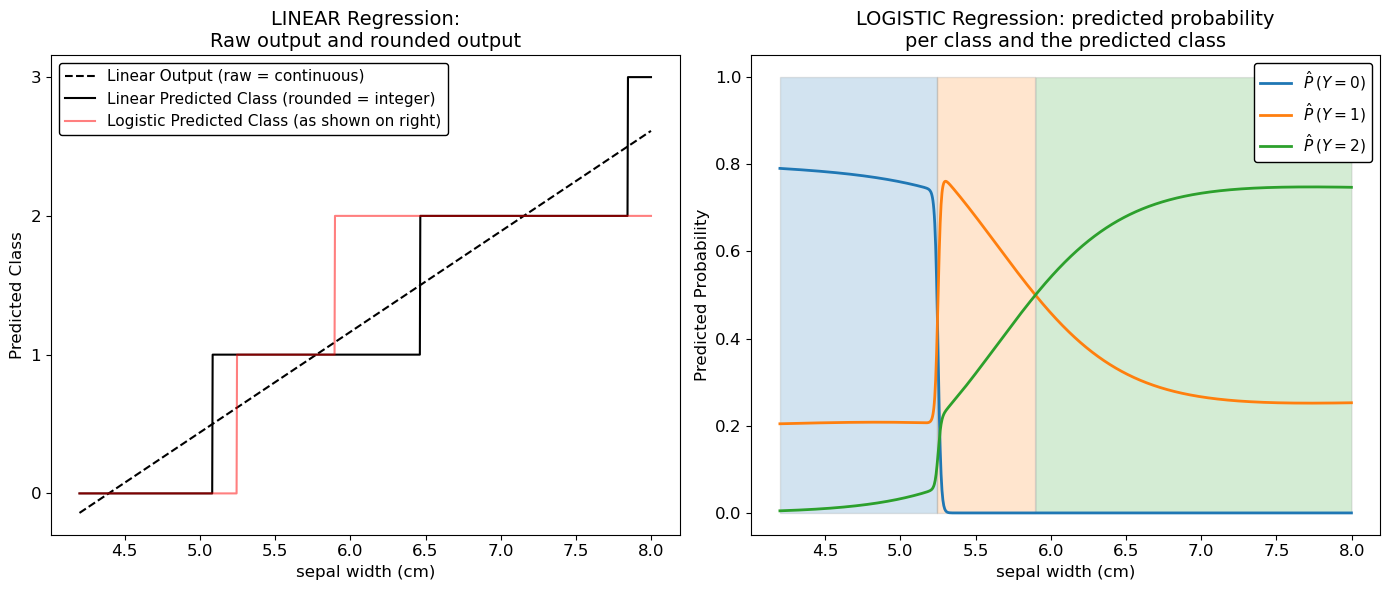

 Logistic Testing Set Accuracy: 82.0%
Linear Testing Set Accuracy: 80.0%


In [42]:
comparison_plot(X_train, y_train, X_test, y_test, label_shift = 0)

# three different logtic regression model
# whichever gives me the max.

#### How does our Logistic Regression come up with mutiple class predictions?


- Each class $y_i$ has a sigmoid function that tries to predict the probability of the tested input belonging to that specific class $y_i$.
  - In our case when we have 3 classes, thus we have 3 sigmoid functions (the blue, orange and green line in the right figure).


- ```LogisticRegression().predict_proba(...)``` : returns probability estimates $P(y_i|x)$ for each $y_i$. In our case ```.predict_proba(...)``` returns 3 values (one for each class). In the figure we observe that : 
  - we have a **high probability of predicting Class 0** in regions with **low 'sepal width' values (left)**.
  - we have a **high probability of predicting Class 1** in regions with **medium 'sepal width' regions (middle)**.
  - have a **high probability of predicting Class 2** in regions with **high 'sepal width' regions (right)**.
  
  
- ```LogisticRegression().predict(...)```: returns 1 value: the predicted class label. The class with the highest probability given by ```.predict_proba(...)``` is exactly the predicted class output of ```.predict(...)```
  - In the figure our final prediction is the **red line**.

<img src="fig/bad_time.jpg" width="600px">

<a id='ex1'></a>

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ GROUP ACTIVITY 1:</strong> Fit and examine a multiclass logistic regression model </div>  

 [▲ Return to contents](#Contents)



- Load and get to know a new dataset
- Select our predictors and response variable
- Generate a train-test-split
- Scale our data
- Perform logistic regression and investigate our results


In [43]:
dataset_wine = datasets.load_wine()
# print(dataset_wine.keys())
# print()
#print(dataset_wine['DESCR'])

In [44]:
X_wine = pd.DataFrame(data=dataset_wine.data, columns=dataset_wine.feature_names)
y_wine = pd.DataFrame(data=dataset_wine.target, columns=['class'])
print(X_wine.shape)
print(y_wine.shape)

(178, 13)
(178, 1)


In [45]:
full_df_wine = pd.concat([X_wine, y_wine], axis=1)
full_df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


Uncomment and run the pairplot in the cell below if you wish to see a scatter-matrix of all variables contained in the wine dataset.

**Please note:** This plotting code will take a minute or so to run.

In [46]:
# sns.pairplot(full_df_wine, hue='class')
# plt.suptitle('Wine dataset features, colored by cultivator class', fontsize=30, y=1)
# plt.show()

- The wine dataset provides many variables to use in our model.

- For the sake of time (and easy visualization), we'll choose to focus solely on 2 predictors: `alcohol` and `flavanoids`.

- Run the code below to subset our full wine dataframe and to perform our train-test-split.

In [47]:
predictors = ['alcohol', 'flavanoids']

full_df_wine_train, full_df_wine_test, = train_test_split(
    full_df_wine[predictors+['class']],
    test_size=0.2,
    random_state=109,
    shuffle=True,
    stratify=full_df_wine['class'],
)

- Now let's take a quick look at our training data to get a sense for how `alcohol` and `flavanoids` relate to one another, as well as to our cultivator `class` response variable. 

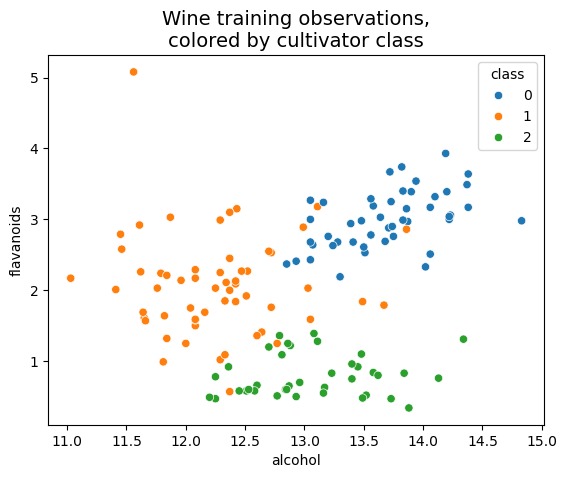

In [48]:
sns.scatterplot(
    data=full_df_wine_train,
    x='alcohol', y='flavanoids',
    hue='class', palette = sns.color_palette("tab10")[:3])
plt.title(
    'Wine training observations,\ncolored by cultivator class',
    fontsize=14
)
plt.show()

**What do you notice about the scale of our two predictor variables?**

- It looks like the mean is shifted, but the total range of values are similar.
- Let's standardize our predictors to center our points and to ensure that both variables are commonly scaled.
- Here we'll fit our scaler only on the training data and then transform both train and test from that training fit. You can justify fitting a scaler on the entire dataset as well, but you should NEVER fit a scaler on the test set alone.

In [49]:
###################################
## SUBSET OUR X AND y DATAFRAMES ##
###################################

X_wine_train, y_wine_train = full_df_wine_train[predictors], full_df_wine_train['class'] 
X_wine_test, y_wine_test = full_df_wine_test[predictors], full_df_wine_test['class']

# print(
#     "Summary statistics for our training predictors BEFORE standardizing:\n\n"
#     "{}\n".format(X_wine_train.describe())
# )

##########################
## SCALE THE PREDICTORS ##
##########################

# Be certain to ONLY EVER fit your scaler on X train (NEVER fit it on test)
scaler = StandardScaler().fit(X_wine_train[predictors])

# Use your train-fitted scaler to transform both X train and X test
X_wine_train[predictors] = scaler.transform(X_wine_train[predictors])
X_wine_test[predictors] = scaler.transform(X_wine_test[predictors])

# print(
#     "Summary statistics for our training predictors AFTER standardizing:\n\n"
#     "{}".format(X_wine_train.describe())
# )

<div class='exercise-r'>  

### Student Exercise:

1. Fit a logistic regression model (name it `model1_wine`) without regularization (i.e. `penalty='none'`) to predict the `class` of each wine using our scaled predictors `alcohol` and `flavanoids`
2. Report on the training and test accuracy of our fitted model
3. Show that for each training prediction, the probability of each predicted class sums to one. (**HINT:** You can use the `predict_proba` method to generate your predicted probabilities.)

</div>

In [50]:
# Give it a shot! 

model1_wine = ...


<div class='exercise-r'>  
     
#### Solution
    
After you've attempted the above exercise, uncomment and run the code below.

</div>

In [53]:
# %load 'solutions/exercise_1_sol.py'
# init exercise 1 solution

# Train model
model1_wine = LogisticRegression(penalty='none').fit(X_wine_train, y_wine_train)

# Score model
train_score = model1_wine.score(X_wine_train, y_wine_train)
test_score = model1_wine.score(X_wine_test, y_wine_test)

# Print scores
print("Training Set Accuracy: {:.4f}".format(train_score))
print("Testing Set Accuracy: {:.4f}\n".format(test_score))

# Predict probabilities for our training data
y_proba_train = model1_wine.predict_proba(X_wine_train)

# Check shape of our predictions to show that we have 3 probabilities predicted
# for each observation (i.e. predicted probabilities for each of our 3 classes)
print(
    "The shape of our predicted training probabilities array: {}\n"
    .format(y_proba_train.shape)
)

# Sum all 3 classes at each observation
print(
    "The sum of predicted probabilities for all 3 classes by observation:\n\n{}"
    .format(np.sum(y_proba_train, axis=1))
)

Training Set Accuracy: 0.9225
Testing Set Accuracy: 0.9444

The shape of our predicted training probabilities array: (142, 3)

The sum of predicted probabilities for all 3 classes by observation:

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [54]:
np.sum(y_proba_train[0])

1.0

<a id='plot'></a>

## 4. Visualize Predictions and Decision boundaries
 [▲ Return to contents](#Contents)

**What are decision boundaries:**
 - In general, a pattern classifier carves up (or 'tesselates' or 'partitions') the feature space into volumes called decision regions. 
 - All feature vectors in a decision region are assigned to the same category.
 
 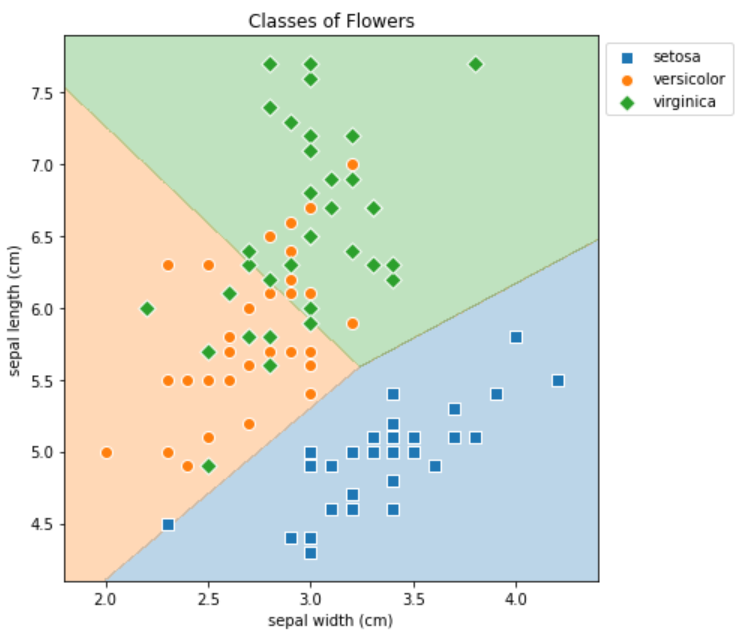

In [55]:
def plot_points(ax, X_train = X_train):
    for i, y_class in enumerate(set(y_train.values.flatten())):
        index = (y_train == y_class).values
        ax.scatter(
            X_train[index]['sepal width (cm)'],
            X_train[index]['sepal length (cm)'],
            c=colors[i],
            marker=markers[i],
            s=65, 
            edgecolor='w',
            label=names[i],
        )

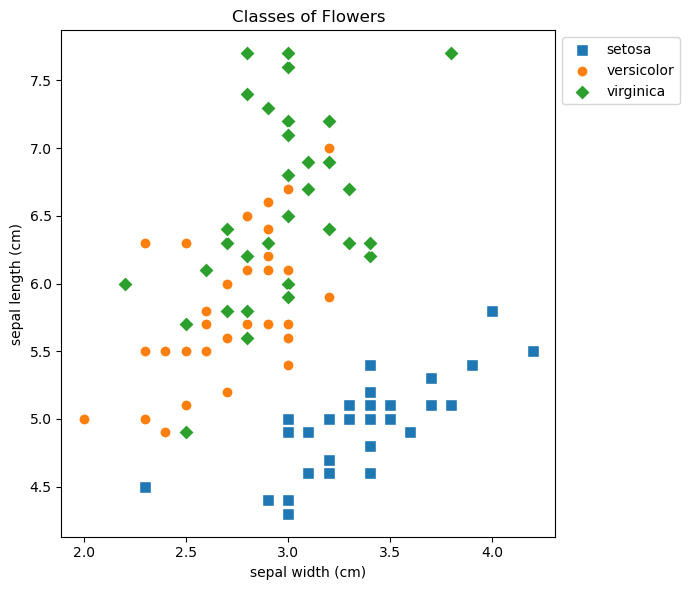

In [56]:
f, ax = plt.subplots(1, 1, figsize=(7, 6))

colors = ["tab:blue", "tab:orange","tab:green"]
markers = ["s", "o", "D"]
names = dataset.target_names

plot_points(ax)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax.set_title('Classes of Flowers')
ax.set_ylabel('sepal length (cm)')
ax.set_xlabel('sepal width (cm)')
plt.tight_layout()
plt.show()

### Plotting the decision boundary by using the following functions:

- **`np.meshgrid()`**

  - `meshgrid` returns coordinate matrices from coordinate vectors, effectively constructing a grid.
  - The documentation: https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html


- **`plt.contourf()`**

  - `contourf` draws filled contours.
  - The documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html


#### What is meshgrid? A quick numpy dive...

How does `meshgrid` work?

Creates two, 2D arrays of all the points in the grid: one for x coordinates, one for y coordinates

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20190326203020/mesh04.png" alt="meshgrid example from geeksforgeeks">

We will go step-by-step to create a 3-by-4 grid below:

In [57]:
x_vector = np.linspace(-6, 6, 2)  # start, stop, num pts
y_vector = np.linspace(-2, 1, 4) 

print(f"x_vector: {x_vector} \t shape: {x_vector.shape}")
print(f"y_vector: {y_vector} \t shape: {y_vector.shape}")

x_vector: [-6.  6.] 	 shape: (2,)
y_vector: [-2. -1.  0.  1.] 	 shape: (4,)


In [58]:
# Return 2D x,y points of a grid
x_grid, y_grid = np.meshgrid(x_vector, y_vector)

print(f"x_grid, shape {x_grid.shape}:\n\n{x_grid}\n")
print(f"y_grid, shape {y_grid.shape}:\n\n{y_grid}")

x_grid, shape (4, 2):

[[-6.  6.]
 [-6.  6.]
 [-6.  6.]
 [-6.  6.]]

y_grid, shape (4, 2):

[[-2. -2.]
 [-1. -1.]
 [ 0.  0.]
 [ 1.  1.]]


**Additional `numpy` methods you will notice used in our decision boundary plots:**

- `np.ravel()`, which returns a contiguous flattened array.
- `np.stack()`, which concatenates a sequence of arrays along a new axis.

In [59]:
x_grid_ravel = x_grid.ravel()
y_grid_ravel = y_grid.ravel()

print(f"x_grid.ravel(), shape {x_grid_ravel.shape}:\n\n{x_grid_ravel}\n")
print(f"y_grid.ravel(), shape {y_grid_ravel.shape}:\n\n{y_grid_ravel}")

x_grid.ravel(), shape (8,):

[-6.  6. -6.  6. -6.  6. -6.  6.]

y_grid.ravel(), shape (8,):

[-2. -2. -1. -1.  0.  0.  1.  1.]


In [60]:
xy_grid_stacked = np.stack(
    (x_grid.ravel(), y_grid.ravel()),
    axis=1
) 

print(f"x and y stacked as columns in output:\n\n{xy_grid_stacked}\n")

xy_grid_stacked = np.stack(
    (x_grid.ravel(), y_grid.ravel()),
    axis=0
)

print(f"x and y stacked as rows in output:\n\n{xy_grid_stacked}")

x and y stacked as columns in output:

[[-6. -2.]
 [ 6. -2.]
 [-6. -1.]
 [ 6. -1.]
 [-6.  0.]
 [ 6.  0.]
 [-6.  1.]
 [ 6.  1.]]

x and y stacked as rows in output:

[[-6.  6. -6.  6. -6.  6. -6.  6.]
 [-2. -2. -1. -1.  0.  0.  1.  1.]]


### Now, with our `numpy` review over, let's get back to plotting our boundaries! 

- First, we will create a very fine (spacing of 0.003!) `np.meshgrid` of points to evaluate and color.

In [61]:
x_1 = X_train['sepal width (cm)']
x_2 = X_train['sepal length (cm)']

# Just for illustration purposes we use a margin of 0.2 to the
# left, right, top and bottum of our minimal and maximal points.
# This way our minimal and maximal points won't lie exactly 
# on the axis. 

x_1_min, x_1_max = x_1.min() - 0.2, x_1.max() + 0.2
x_2_min, x_2_max = x_2.min() - 0.2, x_2.max() + 0.2

xx_1, xx_2 = np.meshgrid(
    np.arange(x_1_min, x_1_max, 0.003),
    np.arange(x_2_min, x_2_max, 0.003),
)

- Then, we will generate predictions for each point in our grid and use `plt.contourf` to plot those results!

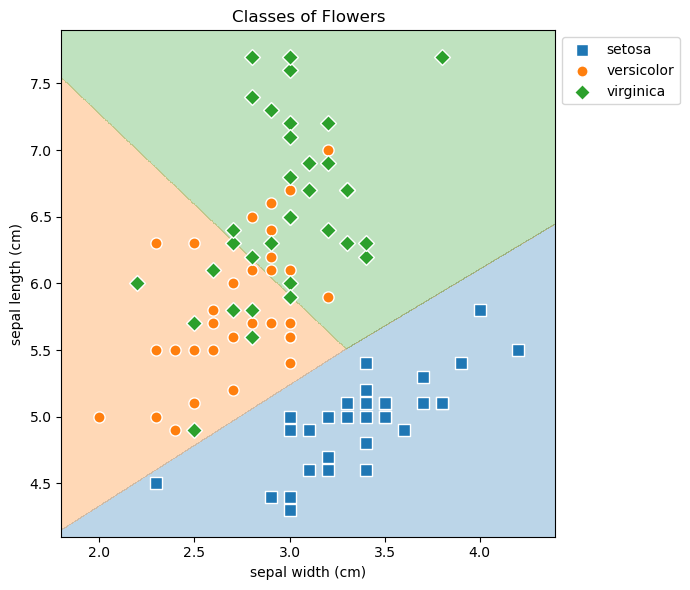

In [62]:
# Plotting decision regions
f, ax = plt.subplots(1, 1, figsize=(7, 6))

X_mesh = np.stack((xx_1.ravel(), xx_2.ravel()),axis=1)

Z = model_logistic.predict(X_mesh)
Z = Z.reshape(xx_1.shape)

# contourf(): Takes in x,y, and z values -- all 2D arrays of same size
ax.contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)

plot_points(ax)
    
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax.set_title('Classes of Flowers')
ax.set_ylabel('sepal length (cm)')
ax.set_xlabel('sepal width (cm)')

plt.tight_layout()
plt.show()

### Why are the decision boundaries of this Logistic Regression linear?

Imagine the simple case where we have only a 2 class classification problem: 

The logistic regression formula can be written as: 
$$
\hat{p} = \cfrac{e^{\beta^T x}}{1+e^{\beta^T x}}
$$

Dividing through by the numerator, This is equivalent to
$$
\hat{p} = \cfrac{1}{1+e^{-\beta^T x}}
$$

Expanding $\beta^T x$, we have $x_1$ (sepal width), $x_2$ (sepal length), and our intercept $x_0$ (constant = 1):

$$
w^T x = 
\begin{bmatrix}
\beta_0 & w\beta_1 & \beta_2 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1 \\ x_2 
\end{bmatrix}
$$

Which makes our formula for $\hat{p}$ equivalent to:

$$
\hat{p} = \cfrac{1}{1 +e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1  \cdot x_1 +  \beta_2 \cdot x_2)}}
$$

Since we don't use multiple higher order polynomial features like $x_1^2, x_2^2$, our logistic model only depends on the first order simple features $x_1$ and $x_2$. 

**What do we have to do to find the the decision boundary?**

The decision boundaries are exactly at the position where our algorithm "hesitates" when predicting which class to classify. The output probability of our sigmoid (or softmax) is exactly 0.5. Solving our sigmoid function for $p=0.5$:

$$
\begin{split}
0.5 &= \cfrac{1}{1 +e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1 x_1 +  \beta_2 x_2)}} \\
0.5 &= \cfrac{1}{1 + 1} \\
e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1  x_1 +  \beta_2 x_2)} &= 1 \\
& \\
-(\beta_0 \cdot 1 + \beta_1  x_1 +  \beta_2 x_2 ) &= 0
\end{split}
$$

When we only use two predictor features this constraint of $p=0.5$ results in a linear system; thus we observe a **linear decision boundary.**

In our case when we have three classes.

**TLDR - The decision boundary for classifier with a threshold of 0.5 is where the linear combination of predictors (the log odds) equals 0.**

-----

<a id='poly'></a>

## 5. Fit a higher order polynomial logistic regression model for classification, compare performance, plot decision boundaries, and interpret results

 [▲ Return to contents](#Contents)

**In this lab we will create degree-2 polynomial features for both of our predictors and re-fit our model and examine the results.**

In [64]:
X_train.head()

,sepal width (cm),sepal length (cm)
96,2.9,5.7
105,3.0,7.6
66,3.0,5.6
0,3.5,5.1
122,2.8,7.7


In [65]:
X_train_poly = X_train.copy()
X_train_poly['sepal width (cm)^2'] = X_train['sepal width (cm)']**2
X_train_poly['sepal length (cm)^2'] = X_train['sepal length (cm)']**2

X_test_poly = X_test.copy()
X_test_poly['sepal width (cm)^2'] = X_test_poly['sepal width (cm)']**2
X_test_poly['sepal length (cm)^2'] = X_test_poly['sepal length (cm)']**2
X_test_poly.head()

,sepal width (cm),sepal length (cm),sepal width (cm)^2,sepal length (cm)^2
73,2.8,6.1,7.84,37.21
18,3.8,5.7,14.44,32.49
118,2.6,7.7,6.76,59.29
78,2.9,6.0,8.41,36.00
76,2.8,6.8,7.84,46.24


In [66]:
#Training
model_logistic_poly = LogisticRegression(penalty="none").fit(X_train_poly, y_train)

#Predict
y_pred_train = model_logistic_poly.predict(X_train_poly)
y_pred_test = model_logistic_poly.predict(X_test_poly)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 81.0%
Testing Set Accuracy: 72.0%


<div class='exercise-r'>  

**Our test performance is decreasing, what might be happening?**

</div>

 - How would you test if this is happening? 
 - How would you inhibit this phenomenon from happening?

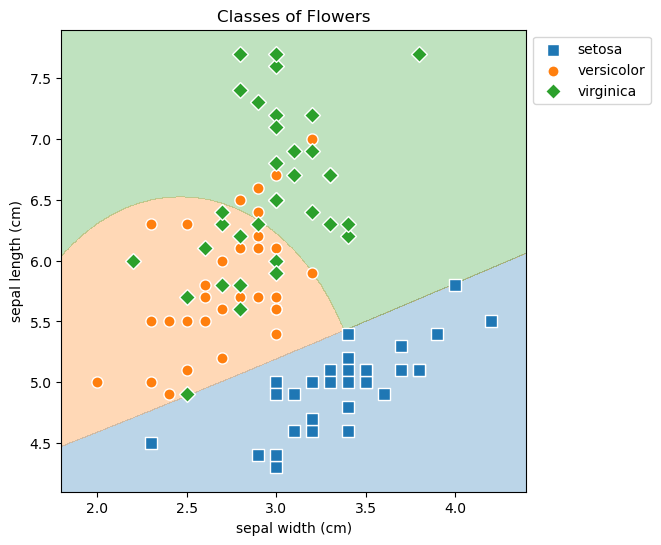

In [67]:
# Plotting decision regions
f, ax = plt.subplots(1, 1, figsize=(6, 6))

X_mesh_poly = np.stack(
    (xx_1.ravel(), xx_2.ravel(), xx_1.ravel()**2,xx_2.ravel()**2),
    axis=1,
)

Z = model_logistic_poly.predict(X_mesh_poly)
Z = Z.reshape(xx_1.shape)

ax.contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)

plot_points(ax, X_train = X_train_poly)
    
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax.set_title('Classes of Flowers')
ax.set_ylabel('sepal length (cm)')
ax.set_xlabel('sepal width (cm)')
    
plt.show()

<div class='exercise-r'>  

**What do you observe regarding the form of the decision boundaries? Does this make sense?**

</div>

### Decision boundaries for higher order logistic regression 

Let's return to the mathematical representation of our logistic regression model:

$$\hat{p}= \dfrac{e^{\beta^T x}}{1+e^{\beta^T x}}$$

Which is equivalent to: 

$$\hat{p}= \dfrac{1}{1+e^{-\beta^T x}}$$

Now we use $x_1$ (sepal width), $x_2$ (sepal length), an intercept $x_0$ (constant =1), PLUS two higher order terms while making predictions: 

- $x_1^2 = [\text{sepal width}]^2$

- $x_2^2 = [\text{sepal length}]^2$

$$\hat{p}= \cfrac{1}{1+e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1 x_1 +  \beta_2 x_2 + \beta_3 x_1^2 +  \beta_4 x_2^2)}}$$

Now solving for $p=0.5$ results in an equation also dependent on $x_1^2$ and $x_2^2$: thus we observe **non-linear decision boundaries**:

$$
\begin{split}
0.5 &= \cfrac{1}{1 +e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1 x_1 +  \beta_2 x_2 + \beta_3 x_1^2 +  \beta_4 x_2^2)}} \\
0.5 &= \cfrac{1}{1 + 1} \\
e^{\displaystyle -(\beta_0 \cdot 1 + \beta_1 x_1 +  \beta_2 x_2 + \beta_3 x_1^2 +  \beta_4 x_2^2)} &= 1 \\
& \\
-(\beta_0 \cdot 1 + \beta_1 x_1 +  \beta_2 x_2 + \beta_3 x_1^2 +  \beta_4 x_2^2) &= 0
\end{split}
$$

-----

<a id='ex2'></a>

[▲ Return to contents](#Contents)

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ GROUP ACTIVITY 2:</strong> Plot boundaries for our prior team exercise model </div>  


- In this session, we will plot decision boundaries for the `model1_wine` model we fit during Team Exercise #1.

<div class='exercise-r'>  
 
### Student Exercise:

Using the `plot_wine_2d_boundaries` function provided below, you are going to plot the TRAINING data decision boundaries for `model1_wine` from team exercise 1 above.

**To do this, you will need to:**

1. Define an appropriate `xx_1_wine` and `xx_2_wine` for input into this function using `np.meshgrid`
2. And call `plot_wine_2d_boundaries` specifying the appropriate input parameters
    
</div>

In [68]:
# We give you the plotting function here
def plot_wine_2d_boundaries(X_data, y_data, predictors, model, xx_1, xx_2):
    """Plots 2-dimensional decision boundaries for a fitted sklearn model
    
    :param X_data: pd.DataFrame object containing your predictor variables
    :param y_data: pd.Series object containing your response variable
    :param predictors: list of predictor names corresponding with X_data columns
    :param model: sklearn fitted model object
    :param xx_1: np.array object of 2-dimensions, generated using np.meshgrid
    :param xx_2: np.array object of 2-dimensions, generated using np.meshgrid
    """

    def plot_points(ax):
        for i, y_class in enumerate(set(y_data.values.flatten())):
            index = (y_data == y_class).values
            ax.scatter(
                X_data[index][predictors[0]],
                X_data[index][predictors[1]],
                c=colors[i],
                marker=markers[i],
                s=65, 
                edgecolor='w',
                label="class {}".format(i),
            )

    # Plotting decision regions
    f, ax = plt.subplots(1, 1, figsize=(7, 6))

    X_mesh = np.stack((xx_1.ravel(), xx_2.ravel()), axis=1)

    Z = model.predict(X_mesh)
    Z = Z.reshape(xx_1.shape)

    ax.contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)

    plot_points(ax)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    ax.set_title(
        'Wine cultivator class prediction\ndecision boundaries',
        fontsize=16
    )
    ax.set_xlabel(predictors[0], fontsize=12)
    ax.set_ylabel(predictors[1], fontsize=12)

    plt.tight_layout()
    plt.show()

<div class='exercise-r'>  
 
#### Enter your code below
    
</div>

In [69]:
## Your code here

# Give exercise 2 a try! Just adapt the iris code to the wine dataset

# Create your meshgrid arrays similar to xx_1 and xx_2
# Be certain to use reasonable min and max bounds for your data

xx_1_wine, xx_2_wine = ..., ...

# Then plot your boundaries

# plot_wine_2d_boundaries( ... )

-----

<div class='exercise-r'>  
    
#### Solution
    
After you've attempted the above exercise, uncomment and run the code below.

</div>

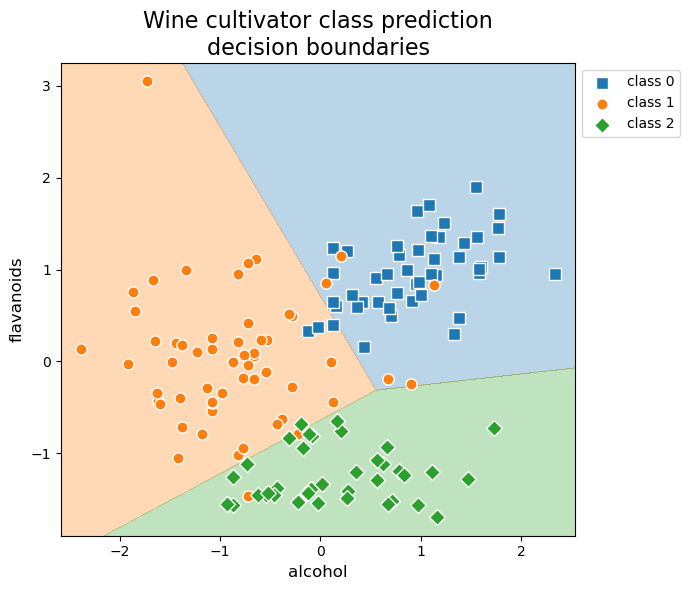

In [71]:
# %load 'solutions/exercise_2_sol.py'
# init exercise 2 solution

# Using an approach similar to what was used in the Iris example
# we can identify appropriate boundaries for our meshgrid by
# referencing the actual wine data

x_1_wine = X_wine_train[predictors[0]]
x_2_wine = X_wine_train[predictors[1]]

x_1_min_wine, x_1_max_wine = x_1_wine.min() - 0.2, x_1_wine.max() + 0.2
x_2_min_wine, x_2_max_wine = x_2_wine.min() - 0.2, x_2_wine.max() + 0.2

# Then we use np.arange to generate our interval arrays
# and np.meshgrid to generate our actual grids

xx_1_wine, xx_2_wine = np.meshgrid(
    np.arange(x_1_min_wine, x_1_max_wine, 0.003),
    np.arange(x_2_min_wine, x_2_max_wine, 0.003)
)

# Now we have everything we need to generate our plot

plot_wine_2d_boundaries(
    X_wine_train,
    y_wine_train,
    predictors,
    model1_wine,
    xx_1_wine,
    xx_2_wine,
)

-----

<a id='regularize'></a>

## 6. Fit regularized polynomial logistic regression models and examine the results

 [▲ Return to contents](#Contents)

<div class='exercise-r'>  
    
**What do you expect to happen to our decision boundaries if we apply regularization to our polynomial regression model?**

</div>

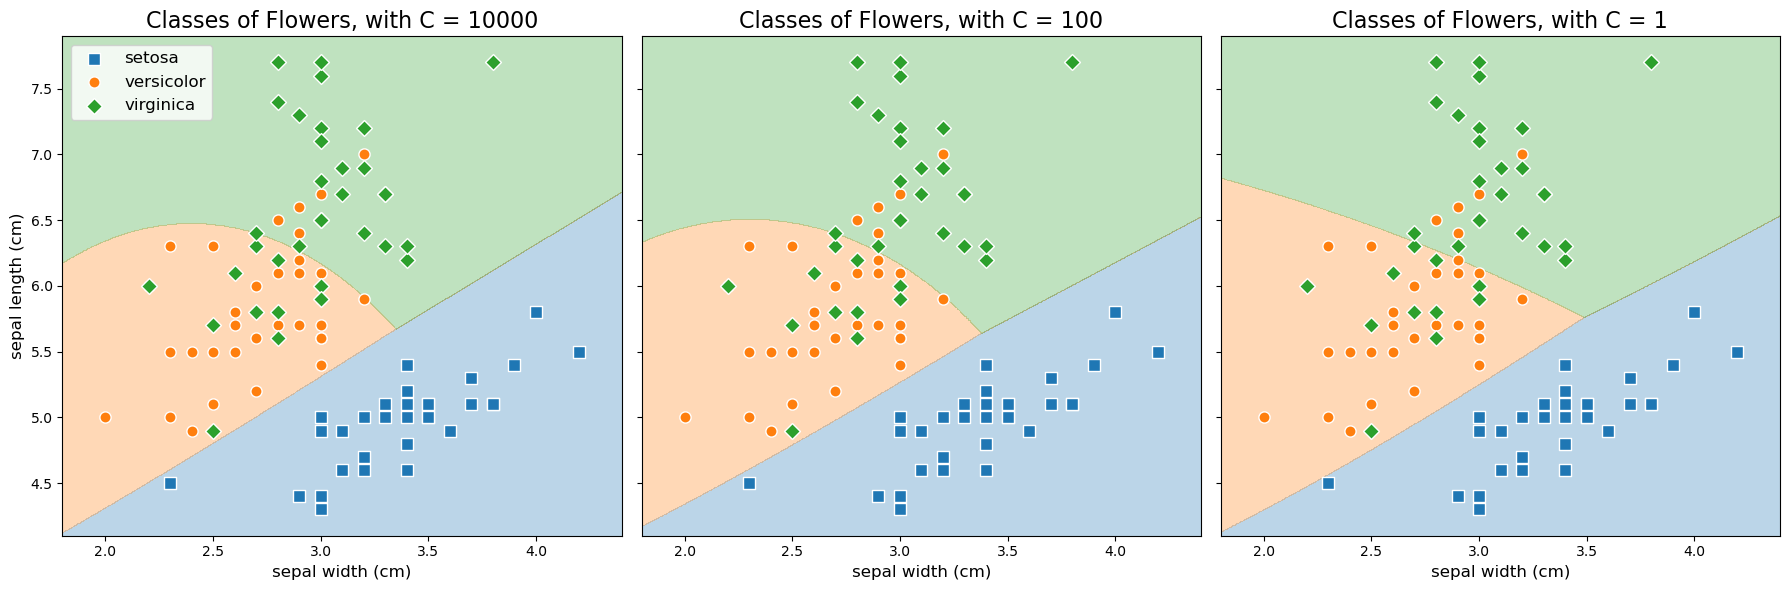

CPU times: user 2.51 s, sys: 2 s, total: 4.51 s
Wall time: 1.07 s


In [72]:
%%time

f, ax = plt.subplots(1, 3, sharey=True, figsize=(6*3, 6))

model_logistics =[]
model_logistics_test_accs_scores =[]
model_logistics_train_accs_scores =[]

for test, C in enumerate([10000, 100, 1]):
    model_logistics.append(LogisticRegression(C=C).fit(X_train_poly, y_train))
    
    y_pred_train = model_logistics[test].predict(X_train_poly)
    y_pred_test = model_logistics[test].predict(X_test_poly)
    model_logistics_train_accs_scores.append(accuracy_score(y_train, y_pred_train)*100)
    model_logistics_test_accs_scores.append(accuracy_score(y_test, y_pred_test)*100)

    Z = model_logistics[test].predict(X_mesh_poly)
    Z = Z.reshape(xx_1.shape)

    ax[test].contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)
    plot_points(ax[test])

    ax[test].set_title('Classes of Flowers, with C = '+ str(C), fontsize=16)
    ax[test].set_xlabel('sepal width (cm)', fontsize=12)
    
    if test==0:
        ax[test].legend(loc='upper left', ncol=1, fontsize=12)
        ax[test].set_ylabel('sepal length (cm)', fontsize=12)
    
plt.tight_layout()
plt.show()

**What do you observe?**

 - How are the decision boundaries looking?
 - What happens when the regularization term `C` changes? 
 - You may want to look at the documentation of `sklearn.linear.LogisticRegression()` to see how the `C` argument works:

In [73]:
# To get the documentation uncomment and run the following command:

# LogisticRegression?

**What do expect regarding the evolution of the norm of the coefficients of our models when the regularization term `C` changes?**

Our list contains all 3 models with different values for `C` (**take a look at the first parameter within brackets**)

In [74]:
model_logistics

[LogisticRegression(C=10000),
 LogisticRegression(C=100),
 LogisticRegression(C=1)]

In [75]:
for test, model in enumerate(model_logistics):
    print('\nRegularization parameter : \tC = {}'.format(model.C))
    print("Training Set Accuracy : \t{}".format(model_logistics_train_accs_scores[test])+'%')
    print("Testing Set Accuracy : \t\t{}".format(model_logistics_test_accs_scores[test])+'%')
    print('Mean absolute coeficient : \t{:0.2f}'.format(np.mean(np.abs(model.coef_))))


Regularization parameter : 	C = 10000
Training Set Accuracy : 	83.0%
Testing Set Accuracy : 		78.0%
Mean absolute coeficient : 	5.99

Regularization parameter : 	C = 100
Training Set Accuracy : 	83.0%
Testing Set Accuracy : 		78.0%
Mean absolute coeficient : 	2.28

Regularization parameter : 	C = 1
Training Set Accuracy : 	83.0%
Testing Set Accuracy : 		80.0%
Mean absolute coeficient : 	0.37



**Interpretation of Results: What happens when our Regularization Parameter decreases?**

The amount of regularization increases, and this results in:

- The training set accuracy decreasing a little bit (not much of a problem)


- The TEST Accuracy INCREASING a little bit (better generalization!)


- The size of our coefficents DECREASES on average.


<a id='ex3'></a>

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ GROUP ACTIVITY 3:</strong> Tune and fit a Lasso regularized model using cross-validation. </div>  

 [▲ Return to contents](#Contents)

- Perform Lasso regularized logistic regression and choose an appropriate `C` by using cross-validation


- Confirm whether any predictors are identified as unimportant (i.e. $w_i=0$)



**There are a number of different tools built into `sklearn` that help you to perform cross-validation.**

- A lot of examples in this class so far have used `sklearn.model_selection.cross_validate` as the primary means for peforming cross-validation.


- **BUT WAIT!!!** As it turns out, `sklearn` provides a very useful tool for performing logistic regression cross-validation across a range of regularization hyperparameters.

**For this problem, you should use the `sklearn.linear_model.LogisticRegressionCV`.**

<div class='exercise-r'>  

### Student Exercise:

1. Add a new predictor to your `X` data measuring the interaction between `alcohol` and `flavanoid` (make certain to do this for both your training and TEST `X` dataframes).

    
2. Please review the documentation to learn how to fit and use the `LogisticRegressionCV` model object: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

    
3. Using `LogisticRegressionCV` to fit your model, perfrom cross-validation with `3` k-folds, Lasso-like regularization, and the following list of regularization parameters `[1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]`.

    
4. Print (1) the regularization parameter chosen by the model, (2) your train and test accuracies, and (3) your model coefficients (including the intercept).

</div>

In [76]:
## Your code here.


<div class='exercise-r'>  
    
#### Solution
    
After you've attempted the above exercise, uncomment and run the code below.
    
</div>

In [77]:
# %load 'solutions/exercise_3_sol.py'
# init exercise 3 solution

# create interaction term for both train and test sets

for df in [X_wine_train, X_wine_test]:
    df["_".join(predictors)] = df[predictors[0]] * df[predictors[1]]

# View the resulting dataframe
display(X_wine_train.head())

print()

# Fit cv logistic regression model to predictors (including interaction term)

Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 3
penalty = 'l1'
solver = 'liblinear'

model2_wine = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver='liblinear'
).fit(X_wine_train, y_wine_train)

model2_score_train = model2_wine.score(X_wine_train, y_wine_train)
model2_score_test = model2_wine.score(X_wine_test, y_wine_test)

model2_coefficients = np.hstack(
    [model2_wine.intercept_.reshape(-1, 1), model2_wine.coef_]
).T

print(
    "The regularization parameter C chosen by this model for each class "
    "was:\n\n\t{}\n\n"
    "The accuracy scores for this model are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}\n"
    .format(model2_wine.C_, model2_score_train, model2_score_test)
)

print(
    "The coefficients for this model by class are:"
    "\n\n\t\t\t\tclass\n\t\t\t\t0\t\t1\t\t2\n"
)

coef_names = ["intercept"] + list(X_wine_train.columns)

for name, values in zip(coef_names, model2_coefficients):
    coefs_formatted = ["{:.4f}".format(val) for val in values]
    print("\t{}   \t\t{}".format(name, "\t\t".join(coefs_formatted)))

-------

## 7. kNN Classification

 [▲ Return to contents](#Contents)

**In this lab, we will fit a kNN-classification model, plot our decision boundaries, and interpret the results.**

You can read the `KNeighborsClassifier` documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [78]:
#Training
model_KNN_classifier = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [79]:
#Predict
y_pred_train = model_KNN_classifier.predict(X_train)
y_pred_test = model_KNN_classifier.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 96.0%
Testing Set Accuracy: 70.0%


The fact we have a big gap of performance between the test and training set means we are overfitting. This can be explained by our choice to use `n_neighbors=1`.

<div class='exercise-r'>  

- **Based on your knowledge of kNN-regression can you guess how the decision boundary of the kNN-classification will look when using "n_neighbors=1"?**
  

- **How about if we were to increase that number to "n_neighbors=50" or "n_neighbors=100" (our total number of training observations)?**

</div>

**Please note:** *The below code cell will take several minutes to run, primarily because of the large number of values in our meshgrid against which each kNN model must generate predictions.*

**What does this tell us about the efficiency of the kNN algorithm vs. regularized logistic regression?**

- Notice that the comparable set of 3 subplots generated using logistic regression only took about 1 second to run.

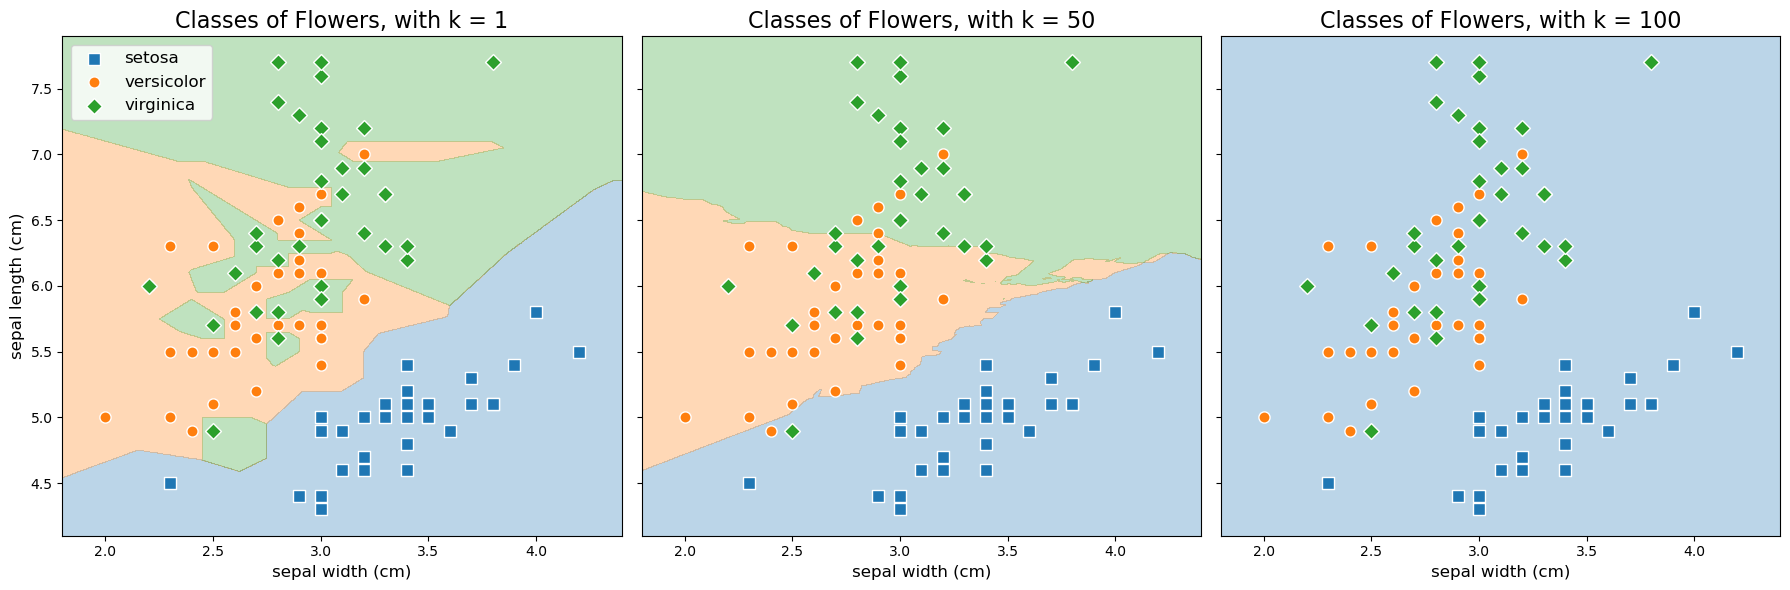

In [80]:
# Similar to what we did above for varying values C
# let's explore the effect that k in kNN classification has on our decision boundaries
ks = [1, 50, 100]

X_mesh = np.stack((xx_1.ravel(), xx_2.ravel()),axis=1)
Z = model_logistic.predict(X_mesh)
Z = Z.reshape(xx_1.shape)

f, ax = plt.subplots(1, 3, sharey=True, figsize=(6*3, 6))

model_ks = []
model_ks_test_accs_scores = []
model_ks_train_accs_scores = []

for test, k in enumerate(ks):
    model_ks.append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train))
    
    y_pred_train = model_ks[test].predict(X_train)
    y_pred_test = model_ks[test].predict(X_test)
    model_ks_train_accs_scores.append(accuracy_score(y_train, y_pred_train)*100)
    model_ks_test_accs_scores.append(accuracy_score(y_test, y_pred_test)*100)

    Z = model_ks[test].predict(X_mesh)
    Z = Z.reshape(xx_1.shape)

    ax[test].contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)
    plot_points(ax[test])

    ax[test].set_title('Classes of Flowers, with k = '+ str(k), fontsize=16)
    ax[test].set_xlabel('sepal width (cm)', fontsize=12)
    
    if test==0:
        ax[test].legend(loc='upper left', ncol=1, fontsize=12)
        ax[test].set_ylabel('sepal length (cm)', fontsize=12)
    
plt.tight_layout()

<div class='exercise-r'>  

- **What do you notice in the plots above in regards to our decision boundaries as $k$ increases?**
- **What implications might this have for our Train vs. Test accuracies at each value $k$?**
- **If we wanted to tune our kNN classification model to find the best value $k$ given our data, what approach should we take?** (You better say "cross-validation" with many values $k$!)

</div>

## Reviewing `sklearn` pipelines (optional)

 [▲ Return to contents](#Contents)

**Pipelines can be used to to sequentially apply a list of transforms (e.g. scaling, polynomial feature creation) and a final estimator.**

Instead of manually building our polynomial features which might take a lot of lines of code we can use a **pipeline** to sequentially create polynomials before fitting our logistic regression. Scaling can also be done inside the ```make_pipeline```.

The documentation: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

**Previously we did:**

```python
X_train_poly_cst=X_train_cst.copy()
X_train_poly_cst['sepal width (cm)^2'] = X_train_cst['sepal width (cm)']**2
X_train_poly_cst['sepal length (cm)^2'] = X_train_cst['sepal length (cm)']**2

X_test_poly_cst=X_test_cst.copy()
X_test_poly_cst['sepal width (cm)^2'] = X_test_poly_cst['sepal width (cm)']**2
X_test_poly_cst['sepal length (cm)^2'] = X_test_poly_cst['sepal length (cm)']**2 
```

**Now it is a one-liner:**

```python
make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LogisticRegression())
```

In [81]:
# your code here
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2,include_bias=False),
    LogisticRegression(),
)

#Training
polynomial_logreg_estimator.fit(X_train_poly, y_train)

#Predict
y_pred_train = polynomial_logreg_estimator.predict(X_train_poly)
y_pred_test = polynomial_logreg_estimator.predict(X_test_poly)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

Training Set Accuracy: 80.0%
Testing Set Accuracy: 74.0%


----------------------